In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import filterwarnings
filterwarnings(action="ignore")
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
def wrangle(dataset):
    # Read dataset into memory
    data = pd.read_csv(dataset)

    # Instantiate relevant classes
    label_encoder = LabelEncoder()
    scaler = StandardScaler()

    # Label encode Genders
    data["Gender"] = label_encoder.fit_transform(data["Gender"])
    
    # Deal with high and low cardinal features
    data.drop(["CustomerId", "RowNumber", "Surname"], axis=1, inplace=True)
    
    # Bin data based on age_groups
    data["Age_cat"] = pd.cut(data["Age"], bins=[18,25,40,50,60,70,96], labels=["18-25","26-40","41-50", "51-60", "61-70", "71-96"])
    data["Age_cat"].fillna(method="ffill", inplace=True)
    data.drop("Age", axis = 1, inplace=True)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data["Age_cat"]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]

    
    train = strat_train_set
    test = strat_test_set
    
    # Create one_hot columns based on age_groups and countries
    # Split features and targets
    train = pd.get_dummies(train, columns=["Geography", "Age_cat"], prefix_sep='')
    train_target = train["Exited"]
    train_features = train.drop("Exited", axis=1)
    test = pd.get_dummies(test, columns=["Geography", "Age_cat"], prefix_sep='')
    test_target = test["Exited"]
    test_features = test.drop("Exited", axis=1)
    names = list(test_features.columns)
    train_features, test_features = scaler.fit_transform(train_features), scaler.fit_transform(test_features)

    output = {"X_train" : train_features, "X_test":test_features, "y_train":train_target, "y_test":test_target, "names":names}
    return output

In [3]:
data = wrangle("Churn_Modelling.csv")

####  Examining the dataset

In [4]:
X_train, y_train = data["X_train"], data["y_train"]
X_test,  y_test = data["X_test"], data["y_test"]

#### Logistic Regression

In [5]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)
test_pred = log_model.predict(X_test)
print(f"Accuracy Score:{accuracy_score(y_test, test_pred)}")
print(classification_report(y_test, test_pred))

Accuracy Score:0.821
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1590
           1       0.64      0.28      0.39       410

    accuracy                           0.82      2000
   macro avg       0.74      0.62      0.64      2000
weighted avg       0.80      0.82      0.79      2000



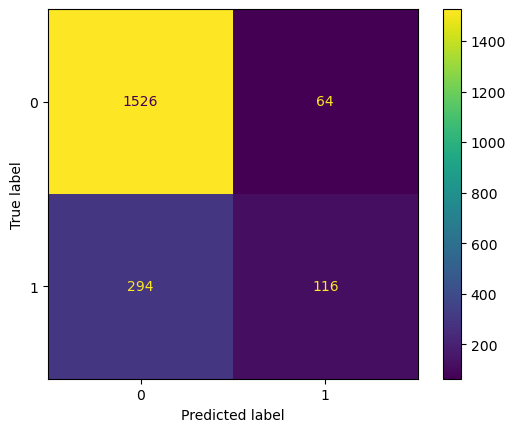

In [6]:
cm_logreg = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm_logreg)
disp.plot();

#### Decision Tree

In [7]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_model.fit(X_train, y_train)
tree_test_pred = tree_model.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, tree_test_pred)}")
print(classification_report(y_test, tree_test_pred))

Accuracy Score: 0.851
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1590
           1       0.70      0.48      0.57       410

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000



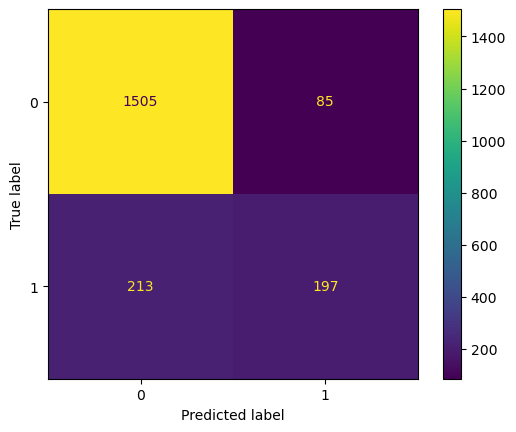

In [8]:
cm_tree_clf = confusion_matrix(y_test, tree_test_pred)
disp = ConfusionMatrixDisplay(cm_tree_clf)
disp.plot();

In [9]:
importances = list(tree_model.feature_importances_)
names = data["names"]
frame = pd.DataFrame({"names":names, "importance":importances})

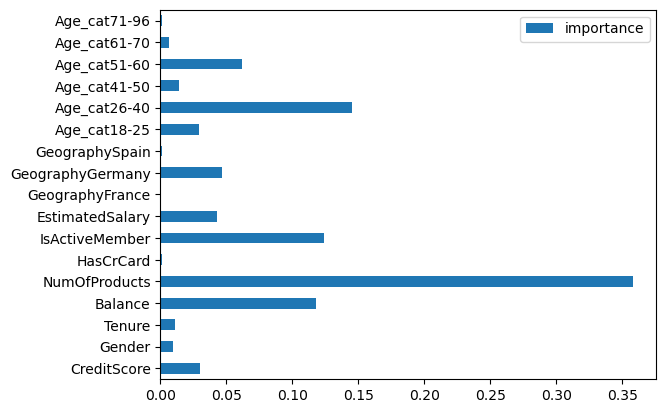

In [10]:
frame.plot(kind="barh")
plt.yticks(range(frame.shape[0]), list(frame.names));

#### Random Forest

In [11]:
forest_model = RandomForestClassifier(random_state=42, max_depth=15)
forest_model.fit(X_train, y_train)
forest_test_pred = forest_model.predict(X_test)
print(f"Accuracy Score:{accuracy_score(y_test, forest_test_pred)}")
print(classification_report(y_test, forest_test_pred))

Accuracy Score:0.861
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1590
           1       0.77      0.46      0.57       410

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



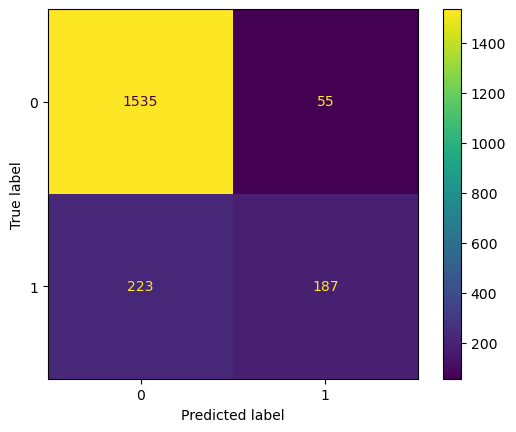

In [12]:
cm_for_clf = confusion_matrix(y_test, forest_test_pred)
disp = ConfusionMatrixDisplay(cm_for_clf)
disp.plot();

In [13]:
importances = list(forest_model.feature_importances_)
names = data["names"]
frame = pd.DataFrame({"names":names, "importance":importances})

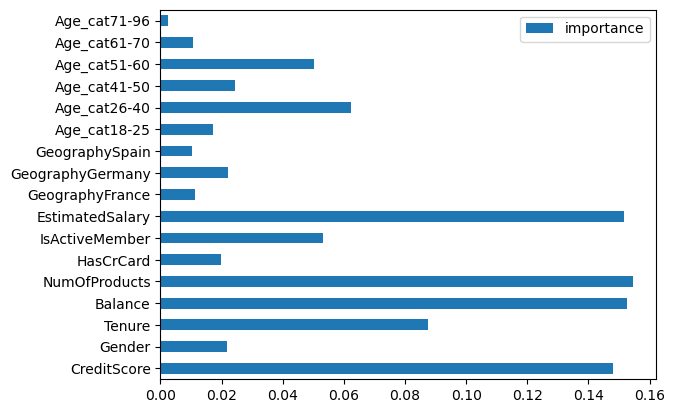

In [14]:
frame.plot(kind="barh")
plt.yticks(range(frame.shape[0]), list(frame.names));

In [15]:
params_grid = [{"max_depth":[i for i in range(1, 10)]}]
params__grid = [{"max_depth":[i for i in range(1, 16)], "n_estimators":[i for i in range(10,110,10)]}]

In [16]:
dec_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(dec_tree, params_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]}])

In [17]:
pred = grid_search.best_estimator_.predict(X_test)

In [18]:
print(f"Accuracy Score:{accuracy_score(y_test, pred)}")
print(classification_report(y_test, pred))

Accuracy Score:0.8525
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1590
           1       0.70      0.49      0.58       410

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000



#### Forest CV

In [19]:
rfclf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfclf, params__grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100]}])

In [20]:
rfclf_pred = grid_search.best_estimator_.predict(X_test)

In [21]:
print(f"Accuracy Score:{accuracy_score(y_test, rfclf_pred)}")
print(classification_report(y_test, rfclf_pred))

Accuracy Score:0.8585
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1590
           1       0.77      0.44      0.56       410

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [30]:
gbm = GradientBoostingClassifier(max_depth=7)
#grid_search = GridSearchCV(gbm, params__grid)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7)

In [31]:
pred = gbm.predict(X_test)

In [32]:
print(f"Accuracy Score:{accuracy_score(y_test, pred)}")
print(classification_report(y_test, pred))

Accuracy Score:0.851
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1590
           1       0.71      0.47      0.56       410

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

